In [18]:
import sys
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
ROOT = os.path.abspath('../')
sys.path.append(ROOT)
import models
from util import *
from sklearn import manifold
import re
import itertools
import pickle

In [2]:
DATA_DIR = os.path.join(ROOT,'data')
MODEL_DIR = os.path.join(ROOT,'models')
LOG_DIR = os.path.join(ROOT,'logs')
CHECKPT_DIR = os.path.join(LOG_DIR,'checkpoints')
ENCODE_DIR = os.path.join(LOG_DIR,'encodings')
# MODEL = 'jplu/tf-xlm-roberta-base' 
MODEL = 'distilroberta-base' 
N_EPOCHS = 2
BATCH_SIZE = 32
tf.keras.backend.clear_session()

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)
train_raw = pd.read_csv(os.path.join(DATA_DIR,'jigsaw-toxic-comment-train-processed-seqlen128.csv.zip'))
train = pd.concat([train_raw.query('toxic==0').sample(60000,random_state=1),
                           train_raw.query('toxic==1')]).sample(frac=1)

validation_data = pd.read_csv(os.path.join(DATA_DIR,'validation.csv.zip'))
test_data = pd.read_csv(os.path.join(DATA_DIR,'test.csv.zip'))


In [5]:
SAVE_ENCODING=False
LOAD_ENCODING = True

In [6]:
if LOAD_ENCODING:
    FILE_NAME  =MODEL.replace('/','-')
    with open(ENCODE_DIR+'\\{0}_encoding.npy'.format(FILE_NAME),'rb') as f:
        x_train=np.load(f)
        y_train=np.load(f)
        x_validate=np.load(f)
        y_validate=np.load(f)
        x_test=np.load(f)
else:
    tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)
    x_train = batch_encode(train.comment_text.values,tokenizer, max_len =  models.MAX_LEN)
    x_validate = batch_encode(validation_data.comment_text.values,tokenizer, max_len =  models.MAX_LEN)
    x_test = batch_encode(test_data.content.values,tokenizer, max_len =  models.MAX_LEN)
    y_train = train.toxic.values
    y_validate = validation_data.toxic.values
    if SAVE_ENCODING:
        x_train_enc = np.array(x_train)
        y_train_enc = np.array(y_train)
        x_validate_enc = np.array(x_validate)
        y_validate_enc = np.array(y_validate)
        x_test_enc = np.array(x_test)
        with open(ENCODE_DIR+'\\{0}_encoding.npy'.format(MODEL.replace('/','-')),'wb') as f:
            np.save(f, x_train_enc)
            np.save(f, y_train_enc)
            np.save(f, x_validate_enc)
            np.save(f, y_validate_enc)
            np.save(f, x_test_enc)  

    

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train,y_train))
                 .repeat(1)
                 .shuffle(2048)
                 .batch(BATCH_SIZE)
                 .prefetch(-1))

validate_dataset = (tf.data.Dataset.from_tensor_slices((x_validate,y_validate))
                    .batch(BATCH_SIZE)
                    .prefetch(-1))

test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
               .batch(BATCH_SIZE)
               .prefetch(-1))

In [8]:
config = transformers.AutoConfig.from_pretrained(MODEL,output_hidden_states=True)
transformer = transformers.TFAutoModel.from_pretrained(MODEL,config=config)
model = models.roberta_dense(transformer)
model.compile(tf.keras.optimizers.Adam(1e-5), tf.keras.losses.BinaryCrossentropy(), tf.keras.metrics.BinaryAccuracy())
weights_dir = CHECKPT_DIR + '\\distilroberta-base-roberta_dense\\20200523-151605' 
load_status = model.load_weights(weights_dir)

In [23]:
# model.fit()

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [26]:
train_predict = model.predict(x_train)
np.sum(np.round(train_predict)==y_train[:,None])/y_train.shape[0]

0.9787427504177726

## Analyse Embedding


Hidden layer analysis: How can the layer seperate different data

In [9]:
def model_embedding(model):
    inp = tf.keras.layers.Input(shape=(models.MAX_LEN,),dtype=tf.int32)
    out = model.transformer(inp, training=False)[0][:,0,:]
    emb_model = tf.keras.Model(inputs=inp, outputs=out)
    emb_model.compile()
    return emb_model

def embedding_dense_model(model):
    inp = tf.keras.layers.Input(shape=(models.MAX_LEN,),dtype=tf.int32)
    emb = model.transformer(inp, training=False)[0][:,0,:]
    out = model.dense_layer(emb)
    emb_model = tf.keras.Model(inputs=inp, outputs=out)
    emb_model.compile()
    return emb_model

In [10]:
model_emb = model_embedding(model)

In [11]:
dense_emb = model_emb.predict(x_train)

In [12]:
dense_emb.shape

(81384, 768)

In [13]:
y_train.shape

(81384,)

In [44]:
np.sum((np.round(dense_emb) == y_train[:,None]))/y_train.shape[0]

0.6071709426914381

In [14]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=1)
X_tsne = tsne.fit_transform(dense_emb)

In [19]:
with open(DATA_DIR+'\\x_tsne'+MODEL.replace('/','-')+'.npy','wb') as f:
    pickle.dump(X_tsne,f)


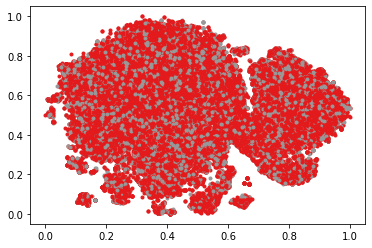

In [17]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
tsne_data = np.concatenate((X_norm, y_train[:,None],train.toxic.values[:,None]),axis=-1)

lang_dict = {'es':0,'it':1,'tr':2}
fig, ax = plt.subplots()

for i in tsne_data:
    ax.plot(i[0],i[1],'.',color=plt.cm.Set1(i[3]))
plt.show()

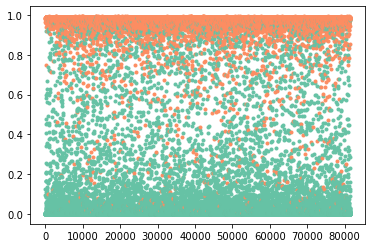

In [14]:
fig,ax = plt.subplots()
for idx, i in enumerate(train_predict):
    ax.plot(idx,i, '.', color=plt.cm.Set2(y_train[idx]))

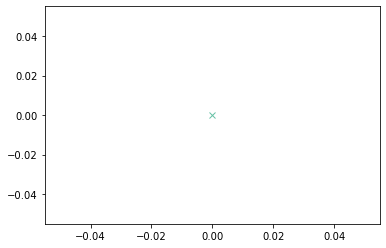

In [34]:
plt.plot(0,0,'x',color=plt.cm.Set2(0))